In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import random

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [10]:
import os
import zipfile
import shutil

# Định nghĩa đường dẫn file zip trong Google Drive và thư mục đích giải nén cục bộ
# Giả định file zip có tên là 'Images.zip' nằm trong cùng thư mục với folder 'Images' hiện tại trong Dataset
zip_file_path = "/content/drive/MyDrive/Dataset/Images.zip"
extracted_dir_path = "/content/Images/Images" # Đường dẫn cục bộ mới cho dữ liệu đã giải nén

# Kiểm tra xem file zip có tồn tại không
if not os.path.exists(zip_file_path):
    print(f"Lỗi: Không tìm thấy file zip tại {zip_file_path}.")
    print("Vui lòng đảm bảo file 'Images.zip' có trong thư mục '/content/drive/MyDrive/Dataset/'.")
else:
    # Tạo thư mục giải nén nếu chưa tồn tại
    if not os.path.exists(extracted_dir_path):
        os.makedirs(extracted_dir_path)

    # Giải nén file zip
    print(f"Đang giải nén {zip_file_path} vào {extracted_dir_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_path)
    print("Giải nén hoàn tất.")

    # Xác minh việc giải nén
    if os.path.exists(os.path.join(extracted_dir_path, 'test')):
        print(f"Dữ liệu đã được giải nén và xác minh thành công vào {extracted_dir_path}.")
    else:
        print("Cảnh báo: Không tìm thấy thư mục con 'test' sau khi giải nén. Vui lòng kiểm tra cấu trúc file zip.")


Đang giải nén /content/drive/MyDrive/Dataset/Images.zip vào /content/Images/Images...
Giải nén hoàn tất.
Dữ liệu đã được giải nén và xác minh thành công vào /content/Images/Images.


In [13]:
# Định nghĩa lớp Config cục bộ để đảm bảo 'config' khả dụng
class Config:
    """ Cấu hình mô hình và huấn luyện """
    # Đường dẫn dữ liệu
    data_dir = "/content/Images/Images" # Đường dẫn đã điều chỉnh cho tập dữ liệu
    # Thông số ảnh
    IMG_HEIGHT = 48
    IMG_WIDTH = 48
    IMG_CHANNELS = 1

    # Tham số huấn luyện
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.0001

    # Các lớp cảm xúc
    CLASSES = ['angry', 'disgust', "fear", "happy", "neutral", "sad", "surprise"]
    NUM_CLASSES = len(CLASSES)

    # Đường dẫn lưu mô hình và lịch sử
    MODEL_SAVE_PATH = "/content/drive/MyDrive/Deep_learning/fer_2013_model.h5"
    WEIGHTS_SAVE_PATH = "fer_2013_weights.h5"
    HISTORY_SAVE_PATH = "training_history.npy"

config = Config()

# ==============================
# 3. Chuẩn bị dữ liệu với Tăng cường dữ liệu (Data Augmentation)
# ==============================
def create_data_generators():
    actual_data_dir = config.data_dir # Mặc định từ lớp Config

    TRAIN_DIR = os.path.join(actual_data_dir, 'train')
    TEST_DIR = os.path.join(actual_data_dir, "test")

    # Kiểm tra thư mục tồn tại trước khi tiếp tục
    if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
        print(f"Lỗi: Không tìm thấy thư mục train hoặc test. Vui lòng đảm bảo tập dữ liệu đã được giải nén đúng tại {actual_data_dir}.")
        raise FileNotFoundError(f"Không tìm thấy thư mục dữ liệu cần thiết tại {TRAIN_DIR} và {TEST_DIR}")

    # Bộ sinh dữ liệu huấn luyện với nhiều tối ưu hóa
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        fill_mode  = "nearest",
        validation_split = 0.2)

    # Bộ sinh dữ liệu xác thực & kiểm tra (chỉ chuẩn hóa lại giá trị pixel)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    # Bộ sinh dữ liệu huấn luyện
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size = (config.IMG_HEIGHT, config.IMG_WIDTH),
        color_mode   = "grayscale",
        batch_size  = config.BATCH_SIZE,
        class_mode  = "categorical",
        shuffle      = True,
        seed        = 42, # Đảm bảo tính ổn định giữa các lần chạy
        subset="training"
    )

    # Bộ sinh dữ liệu xác thực (từ cùng thư mục huấn luyện, dùng validation_split)
    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size = (config.IMG_HEIGHT, config.IMG_WIDTH),
        color_mode = "grayscale",
        batch_size = config.BATCH_SIZE,
        class_mode = "categorical",
        shuffle    = False,
        seed        = 42,      # Đảm bảo tính ổn định giữa các lần chạy
        subset="validation"
    )

    # Bộ sinh dữ liệu kiểm tra
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (config.IMG_HEIGHT, config.IMG_WIDTH),
        color_mode = "grayscale",
        batch_size = config.BATCH_SIZE,
        class_mode = "categorical",
        shuffle     = False
    )

    return train_generator, validation_generator, test_generator

def evaluate_model(model, test_gen):
    print("\n✅ Đang đánh giá mô hình...\n")

    results = model.evaluate(test_gen, verbose=1)

    # Liên kết kết quả với tên các chỉ số
    metrics_names = model.metrics_names  # ['loss', 'accuracy', 'precision', 'recall', 'auc']
    results_dict = dict(zip(metrics_names, results))

    print("\n📊 Kết quả kiểm tra:")
    for name, value in results_dict.items():
        print(f"{name.capitalize()}: {value:.4f}")

    return results_dict.get('accuracy', None)

def predict_and_analyze(model, test_gen):
    print("\n🚀 Dự đoán trên dữ liệu kiểm tra...\n")

    # Dự đoán phân loại
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

    # Báo cáo phân loại
    print("\n📄 Báo cáo phân loại:")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES,
                yticklabels=config.CLASSES)
    plt.title('📊 Ma trận nhầm lẫn')
    plt.xlabel("Dự đoán")
    plt.ylabel('Thực tế')
    plt.show()
    plt.tight_layout()

print("\n" + "="*60)
print(" Sử dụng mô hình đã lưu cho Nhận diện cảm xúc khuôn mặt ")
print("="*60 + "\n")

# 1. Tải mô hình đã huấn luyện
try:
    loaded_model = models.load_model(config.MODEL_SAVE_PATH)
    print(f"✅ Mô hình '{config.MODEL_SAVE_PATH}' đã được tải thành công.")
except Exception as e:
    print(f"❌ Lỗi khi tải mô hình '{config.MODEL_SAVE_PATH}': {e}")
    print("Vui lòng đảm bảo file mô hình tồn tại và đường dẫn chính xác.")
    exit()



 Sử dụng mô hình đã lưu cho Nhận diện cảm xúc khuôn mặt 



✅ Mô hình '/content/drive/MyDrive/Deep_learning/fer_2013_model.h5' đã được tải thành công.


# Upload ảnh để kiểm tra

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import io

# Giả định rằng đối tượng 'config' và 'loaded_model' đã được định nghĩa
# và khả dụng từ các cell trước đó.
# Nếu chưa, bạn cần chạy cell nơi chúng được định nghĩa trước.

def predict_single_image_from_upload(model, config):
    print("\n--- Tải ảnh lên để dự đoán ---")
    uploaded = files.upload()

    if not uploaded:
        print("Không có tệp nào được tải lên.")
        return

    # Lấy tên của tệp đã tải lên
    for fn in uploaded.keys():
        print(f'Người dùng đã tải lên tệp "{fn}"')
        image_path = io.BytesIO(uploaded[fn])

        try:
            # Tải và tiền xử lý ảnh
            img = load_img(image_path, color_mode='grayscale', target_size=(config.IMG_HEIGHT, config.IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
            img_array = img_array / 255.0  # Chuẩn hóa về khoảng 0-1

            # Thực hiện dự đoán
            predictions = model.predict(img_array)
            predicted_class_index = np.argmax(predictions[0])
            predicted_emotion = config.CLASSES[predicted_class_index]
            confidence = predictions[0][predicted_class_index] * 100

            # Hiển thị ảnh và kết quả dự đoán
            plt.figure(figsize=(4, 4))
            plt.imshow(img, cmap='gray')
            plt.title(f"Cảm xúc dự đoán: {predicted_emotion} ({confidence:.2f}%)")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {fn}: {e}")

# Gọi hàm để kiểm tra
# Đảm bảo 'loaded_model' và 'config' khả dụng từ lần chạy trước.
# Nếu bạn chạy cell này độc lập, hãy chắc chắn rằng cell định nghĩa loaded_model và config đã được chạy.
if 'loaded_model' in locals() and 'config' in locals():
    predict_single_image_from_upload(loaded_model, config)
else:
    print("Lỗi: Không tìm thấy 'loaded_model' hoặc 'config'. Vui lòng chạy các cell trước để tải mô hình và định nghĩa config.")


# Lấy 10 ảnh từ tập test để thử nghiệm


--- Hiển thị 10 ảnh kiểm tra ngẫu nhiên với dự đoán ---


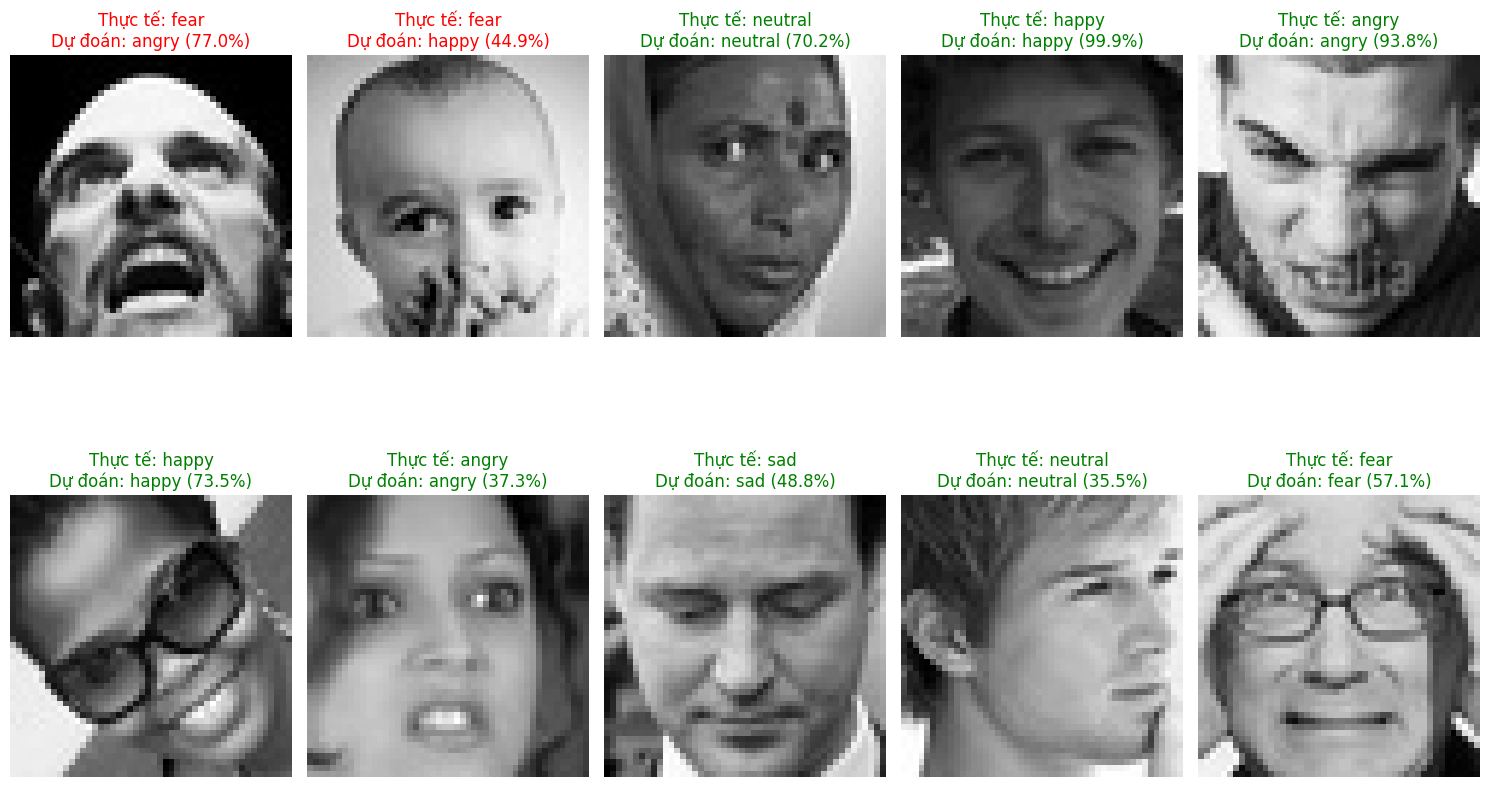

In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Đảm bảo 'loaded_model' và 'config' khả dụng từ lần chạy trước.
# Nếu bạn chạy cell này độc lập, hãy chắc chắn rằng cell định nghĩa loaded_model và config đã được chạy.
if 'loaded_model' not in locals() or 'config' not in locals():
    print("Lỗi: Không tìm thấy 'loaded_model' hoặc 'config'. Vui lòng chạy các cell trước để tải mô hình và định nghĩa config.")
else:
    print("\n--- Hiển thị 10 ảnh kiểm tra ngẫu nhiên với dự đoán ---")

    TEST_DIR = os.path.join(config.data_dir, 'test')

    # Lấy tất cả các lớp cảm xúc từ thư mục test
    emotion_classes = sorted(os.listdir(TEST_DIR))

    # Thu thập đường dẫn của tất cả ảnh kiểm tra
    all_test_image_paths = []
    for emotion in emotion_classes:
        emotion_path = os.path.join(TEST_DIR, emotion)
        if os.path.isdir(emotion_path):
            for img_name in os.listdir(emotion_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_test_image_paths.append((os.path.join(emotion_path, img_name), emotion))

    # Chọn 10 ảnh ngẫu nhiên
    if len(all_test_image_paths) < 10:
        print(f"Cảnh báo: Chỉ tìm thấy {len(all_test_image_paths)} ảnh. Hiển thị tất cả ảnh hiện có.")
        selected_images = random.sample(all_test_image_paths, len(all_test_image_paths))
    else:
        selected_images = random.sample(all_test_image_paths, 10)

    plt.figure(figsize=(15, 10))
    for i, (img_path, true_emotion) in enumerate(selected_images):
        try:
            # Tải và tiền xử lý ảnh
            img = load_img(img_path, color_mode='grayscale', target_size=(config.IMG_HEIGHT, config.IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
            img_array = img_array / 255.0  # Chuẩn hóa về khoảng 0-1

            # Thực hiện dự đoán
            predictions = loaded_model.predict(img_array, verbose=0)
            predicted_class_index = np.argmax(predictions[0])
            predicted_emotion = config.CLASSES[predicted_class_index]
            confidence = predictions[0][predicted_class_index] * 100

            # Hiển thị ảnh và kết quả dự đoán
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Thực tế: {true_emotion}\nDự đoán: {predicted_emotion} ({confidence:.1f}%)",
                      color='green' if true_emotion == predicted_emotion else 'red')
            plt.axis('off')
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_path}: {e}")

    plt.tight_layout()
    plt.show()